En este Notebook se simula la propagación de la envolvente de un campo electrico en una fibra altamente no lineal. Para la simulación se tienen en cuenta las siguientes aproximaciones:


- El campo electrico es quasimonocromatico y tiene una polarización constante a lo largo de la propagación, esto es:

$$\mathbf{E}(\mathbf{r},t)=\frac{\hat{x}}{2} \left(E(\mathbf{r},t) \exp(-i\omega_{0}t)+c.c \right)$$

Con $\Delta \omega \ll \omega_{0}$.

- $\Delta n  $ es pequeño

- Area efectiva independiente de la frecuencia.

- Se usa la siguiente ecuación diferencial:

$$\frac{\partial \tilde{{A}'}}{\partial z}=i\frac{\gamma \omega}{\omega_{0}}\text{exp}(-Lz)\mathfrak{F}\left \{ \bar{A}(z,T)\left[(1-f_{R})|\bar{A}(z,{T}')|^2+\Delta t \mathfrak{F}^{-1}\left \{ \mathfrak{F} (h_{R}(T))\mathfrak{F}(|\bar{A}(z,{T})|^2\right]\right \}\right \}   \hspace{0.5cm} (1)$$

 La función R(T) se conoce como  Raman response function, debe incluir contribuciones nucleares y electronicas (Agrawal), esto es $R(t)=(1-f_R)\delta(t)+f_R h_{R}(t)$, donde  $f_R$ representa la contribucion a la respuesta retardada de Raman y la forma de $h_R$ es dada por la vibración de las moleculas. Escribir la función de respuesta Raman de esta forma impone que las contribuciones electronicas sean instanteas.
 
 
 
# Raman Responde function
 
Dos propuestas presenta el libro para aproximar la función R(T) en la fibra de Silicio:

 $$h_{R}(t)=(\tau_1^{-2}+\tau_2^{-2})\tau_1 \text{exp}(-t/\tau_2)\text{sin}(t/\tau_1) \hspace{0.5cm} (2)$$

Se intentara simular el efecto sobre un pulso de HNLF de thorlabs https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=13874. En nuestro caso, se tiene la fibra HN1550, la cuál tiene los siguientes parametros:

- Nonlinear coeffient: $\gamma=10.8$ $W^{-1} km^{-1}$
- Effective area: $A_{eff}=12.4$ $\mu m^{2}$
- Dispersion: $D=-1$ $ps/(nm \cdot km)$
- Dispersion slope: $\frac{\mathrm{d} D }{\mathrm{d} \lambda}= 0.006$  $ps/(nm^2\cdot km)$
- Mean power: $10$ $mW$
- Pulse width: $200$ $fs$
- Repetition rate: $100$ $MHz$
- Atenuation < $0.9$ $dB/km$

Estos parametros son dados para una longitud de onda de 1550 nm. Los coeficientes de dispersión:

$$\beta_{2}=-\frac{\lambda^2}{2 \pi c} D$$

$$\beta_{3}=\left (\frac{\lambda^2}{2 \pi c}\right)^{2} \left(\frac{2D}{\lambda}+ \frac{\mathrm{d} D }{\mathrm{d} \lambda}\right)$$

# Librerias

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
path='/content/drive/MyDrive/Projects/Ingenieria/Nonlinear_Optics' # Cambiar en caso de tener el proyec
#to en otra carpeta
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#plt.style.use('Solarize_light2')
import seaborn as sns
sns.set_theme()

# Propagación.

Debido a qué en la pagina de thorlabs no se tiene información sobre los parametros $f_r$, $\tau_{1}$ y $\tau_2$ para la ecuación (2) y la función R(t) se debe hacer una 'calibración' de estos parametros usando la grafica del espectro que obtienen luego de propagar un pulso, esto con el fin de acercarnos a los parametros reales.

In [3]:
c = 299792458;            #speed of light [m/s]

def propagar(fr,tau1,tau2):
    
    #Constants
    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    
    #Laser parameters
    WaveLength=1550e-9      #reference wavelength [m]
    global w0 
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    nu=100e6 #Repetition rate (Hz)
    t0 =200e-15       # duration of input [s]
    power = 80e-3/(nu*t0)        #peak power of input [W]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
  
    #Fiber parameters 
    length = 1.0             #ibre length [m]
    D=-1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    beta2=-WaveLength**2/(2*np.pi*c)*D
    beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
    betas=[beta2,beta3]
    gamma = 10.8*1e-3    #nonlinear coefficient [1/W/m]
    loss = 0.5e-3       #loss [dB/m]

    
    #Raman response
    #fr = 0.18                  # fractional Raman contribution

    #tau1 = 12.2e-15; tau2 = 32e-15;

    #fb=0 ; taub=96e-12  

    #fb=0.21 ; taub=96e-12 

    # Response function modified
    RT=((tau1**2
        +tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
        #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))
    
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    fw =np.fft.ifft((A))
    global V
    V=2*np.pi*np.arange(-n/2,n/2,1).T/(n*dT)  # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)

    L=1j*B - alpha/2
    gamma = gamma/w0   
    W = V + w0  
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):

        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE

        IT=np.abs(AT)**2

        AA=np.fft.ifft(IT) #Fourier transform of IT

        RS= fr*np.fft.fft(HW*AA)*dT # Convolution

        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function

        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=200  # Number of points along the distance

    # Z
    z= np.linspace(0,length,nsaves)

    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
    # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n 
        
   

    return y

# Variación de parametros involucrados en la función de respuesta Raman.

En la pagina de https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=13874 se presenta un grafico con los parametros ya enunciados de como es la salida del pulso cuando este se propaga através de la fibra nolineal. Sin embargo, no se especifican los parametros asociados a la función de respuesta Raman, por tanto es necesario realizar una "calibración" antes de propagar los pulsos del laboratorio tratando de asegurarse que nuestra simulación se acerca a la de ellos.

In [4]:
# Datos del espectro de thorlabs
df = pd.read_csv('Epectro_HN1550_80mW_dhms.csv')
Power=np.array(df['Spectrum HN1550_80mW (normalized)'][:]) #Power
Wave=np.array(df['Wavelenght (nm)'][:]) #Power
Wave_new=np.linspace(min(Wave),max(Wave),800)
cs = CubicSpline(Wave, Power)
Power_new=cs(Wave_new)


#popt, pcov = curve_fit(propagar, Wave_new, Power_new,p0=[0.210,173e-15,103e-15])
#power=np.where(power>epsilon1,power,epsilon1)


In [5]:
def anim2(fr,tau1,tau2):
    f = plt.figure(figsize=(10, 2),dpi=200)
    # plot resultados
    #jojasfjas
    
    y=propagar(fr,tau1*1e-15,tau2*1e-15)

    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=1200e-9 ;N2=1800e-9
    iis=np.array([(i>N1 and i<N2) for i in WL])

    epsilon1=1e-40
    In1=np.abs(y.y.T[:,iis])**2/np.amax(np.abs(y.y.T[:,iis])**2)
    In=np.where(In1!=0,In1,In1+epsilon1)
    lIW = 10*np.log10(In) #2*np.pi*c/WL**2) # log scale spectral intensity

    
    plt.plot(WL[iis]*1e9,In1[0],label='in')
    plt.plot(WL[iis]*1e9,In1[-1]/max(In1[-1]),label='out')
    plt.xlabel('$\lambda$ $[nm]$')
    #plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('Normalized Intensity (a.u)' )
    plt.xlim(1300,1800)
    plt.legend()

    plt.plot(Wave,Power,'--r')
    

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        fr= widgets.FloatSlider(min=0.100,max=1,value=1,step=0.01,**opc), 
        tau1= widgets.FloatSlider(min=1,max=2000,value=1,step=1,**opc),
        tau2= widgets.FloatSlider(min= 10,max=2000,value=1,step=1,**opc)
        #mm
        );

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='fr', max=1.0, min=0.1, read…

# Propagación pulsos del laboratorio.

A continuación se propagan los pulsos medidos antes de la HNLF es decir, el pulso amplificado con el fin de comparar con los encontrados experimentalmente. Para ello se usa la implementación anterior salvo algunos detalles:

- Debido a que los pulsos propagados anteriormente eran definidos en un intervalo simetrico entre $ [-f_{nyq},f_{nyq}] $, siendo $f_{nyq}$ la frecuencia de nyquist, los espectros del laboratorio se deben similarmente definir en tal intervalo. Como un intento de simetrizar el intervalo se hara restando al intervalo de frecuencias medido en el lab el valor intermedio de estas.

- Para el muestreo temporal, se tiene en cuenta el criterio de Nyquist asumiendo que el anterior intervalo construido es definido en $ [-f_{nyq},f_{nyq}] $. 

Respecto a los datos experimentales:
En el laboratorio se sabe que el instrumento de medida OSA mide algo que es proporcional a $|\mathfrak{F}\{A(z,t)\}|^{2}$ ya que se relaciona con la energía. Por tanto ya que en la simulación estamos utilizando $\mathfrak{F}\{A(z,t)\}$ para realizar la propagación debemos encontrar la constante de proporcionalidad que relaciona lo simulado con lo experimental.


Para ello se ha medido experimentalmente un espectro amplificado antes de la fibra y su supercontinuo asociado despues de la fibra. Esto permitira hallar la constante de proporcionalidad.


# Función para propagar pulsos del laboratorio.

In [6]:
def propagar_lab(path,k,skip):

    # Load File
    df = pd.read_csv(path,skiprows=skip)
    power=np.array(df['Level(A)'][:])*1e-3 
    #epsilon1=1e-11
    #power=np.where(power>epsilon1,power,epsilon1)
    power=(np.sqrt(power))*k # /np.amax(power)*k  #Power
    
    WL=np.array(df['Wavelength(A)'][:])  #Wavelenght

    #Sampling the simulation.
    wl=1556*1e-9 #Central wavelenght of the spectrum   
    V=np.sort(2*np.pi*c/(1e-9*WL))  #Frequencies.
    midV=(np.max(V)+np.min(V))/2

    V=V - midV# frequency grid

    fw = np.fft.fftshift(power)
    fw=fw.astype('complex')
    n = len(WL)   # number of grid points
    dT = np.pi/V[-1]
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    #Fiber parameters
    length = 2.0             #fibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    D=-1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas=[beta2,beta3]
    gamma = 10*1e-3    #nonlinear coefficient [1/W/m]
    loss = 0.9e-3       #loss [1/m]
    alpha = np.log(10.**(loss/10))   #attenuation coefficient


    #Raman response
    #fr = 0.29                  # fractional Raman contribution

    #tau1 = 168e-15; tau2 = 1000e-15;

    #fb=0 ; taub=96e-12  
    #Raman response
    fr =  0.430                # fractional Raman contribution
    tau1 = 1665e-15; tau2 = 878e-15;
    #fb=0 ; taub=96e-12  #fb=0.21 ; taub=96e-12 # Response function modified
    RT=(tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1)
    #+fb*(2*taub-T)/taub**2*np.exp(-T/taub)# Response function
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2

    #Laser parameters
    WaveLength=1556e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]

    gamma = gamma/w0   
    W = V +midV
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):
            
        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE
        IT=np.abs(AT)**2
        AA=np.fft.ifft(IT) #Fourier transform of IT
        RS= fr*np.fft.fft(HW*AA)*dT # Convolution
        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function
                
        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=10  # Number of points along the distance

    # Z
    z = np.linspace(0,length,nsaves)
  
    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
       # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n


    return y,z
   
    




# Calibración de la simulación.

In [51]:
super_con=[]
propagar=[]

# Cal 1

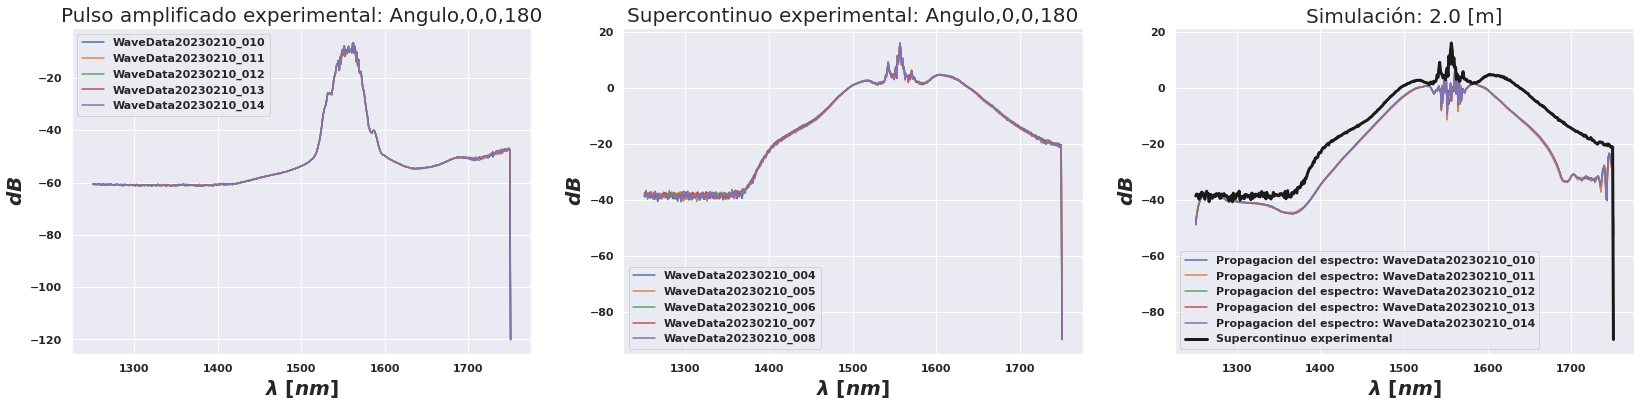

In [52]:
# Load File

f=plt.figure(figsize=(28,6))
names='WaveData20230210_00'
names2='WaveData20230210_0'
pruebaS_1=[names+str(i) for i in range(4,9)]
pruebaP_1=[names2+str(i) for i in range(10,15)]
names_P=[]
names_S=[]


plt.subplot(1,3,1)
for k in range(len(pruebaP_1)):

  path_fileS=path+'/Pulsos_lab/10_feb'+'/'+pruebaS_1[k]+'.csv'
  path_fileP=path+'/Pulsos_lab/10_feb'+'/'+pruebaP_1[k]+'.csv'
  names_P.append(path_fileP)
  names_S.append(path_fileS)

 
  df_P = pd.read_csv(path_fileP,skiprows=52)
  power_P=np.array(df_P['Level(A)'][:])
  WL_P=np.array(df_P['Wavelength(A)'][:])  #Wavelenght
  powerlog_P= 10*np.log10(power_P) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_P,  powerlog_P,label=pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Pulso amplificado experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  plt.legend()

plt.subplot(1,3,2)
for k in range(len(pruebaP_1)):


  df_S= pd.read_csv(names_S[k],skiprows=52)
  power_S=np.array(df_S['Level(A)'][:])
  WL_s=np.array(df_S['Wavelength(A)'][:])  #Wavelenght
  powerlog_S= 10*np.log10(power_S/1e-3) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s, powerlog_S,label=pruebaS_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Supercontinuo experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  #plt.ylim(-100,10)
  plt.legend()



plt.subplot(1,3,3)
for k in range(len(pruebaP_1)):

  skip=52

  y,z=propagar_lab(names_P[k],94,skip)
  epsilon1=1e-40
  In1=np.abs(y.y.T[-1])**2
  #In=np.where(In1!=0,In1,In1+epsilon1)
  lIW = 10*np.log10(In1)+230 #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s,lIW,label='Propagacion del espectro: '+pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Simulación: '+str(round(z[-1],3))+' [m]',fontsize=20)
  plt.ylabel('$dB$',fontsize=20)
  #plt.ylim(-100,10)

  plt.legend()
  

plt.plot(WL_s, powerlog_S,'k',label='Supercontinuo experimental',linewidth=3)
plt.legend()




# Cal 2

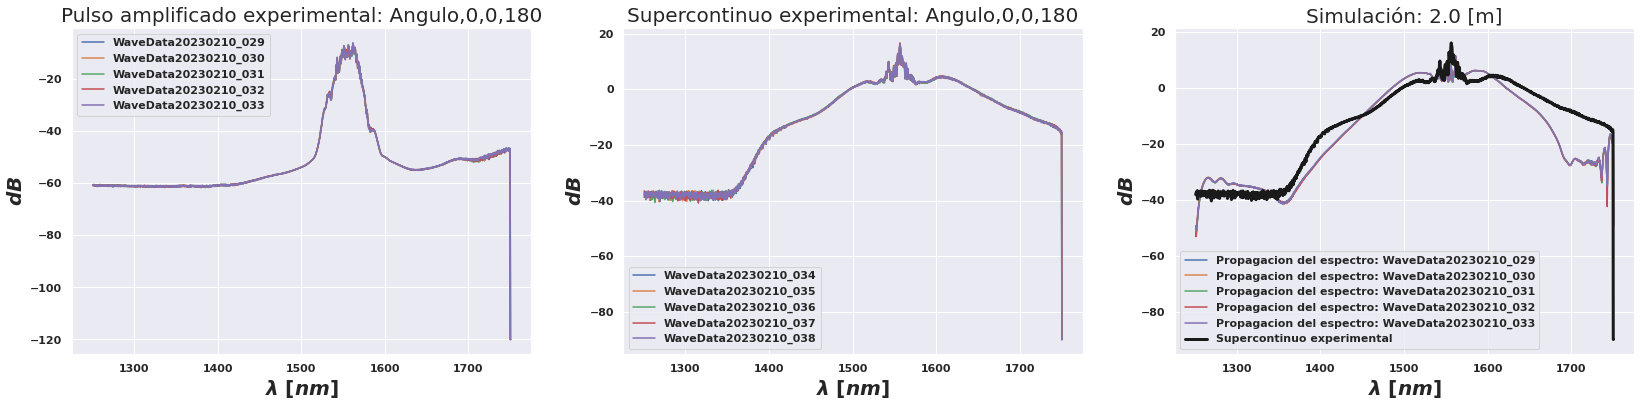

In [53]:
# Load File

f=plt.figure(figsize=(28,6))
names='WaveData20230210_0'
names2='WaveData20230210_0'
pruebaS_1=[names+str(i) for i in range(34,41)]
pruebaP_1=[names2+str(i) for i in range(29,34)]
names_P=[]
names_S=[]


plt.subplot(1,3,1)
for k in range(len(pruebaP_1)):

  path_fileS=path+'/Pulsos_lab/10_feb'+'/'+pruebaS_1[k]+'.csv'
  path_fileP=path+'/Pulsos_lab/10_feb'+'/'+pruebaP_1[k]+'.csv'
  names_P.append(path_fileP)
  names_S.append(path_fileS)

 
  df_P = pd.read_csv(path_fileP,skiprows=52)
  power_P=np.array(df_P['Level(A)'][:])
  WL_P=np.array(df_P['Wavelength(A)'][:])  #Wavelenght
  powerlog_S= 10*np.log10(power_P) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(  WL_P,  powerlog_S,label=pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Pulso amplificado experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  plt.legend()

plt.subplot(1,3,2)
for k in range(len(pruebaP_1)):


  df_S= pd.read_csv(names_S[k],skiprows=52)
  power_S=np.array(df_S['Level(A)'][:])

  WL_s=np.array(df_S['Wavelength(A)'][:])  #Wavelenght
  powerlog_S= 10*np.log10(power_S/1e-3) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s, powerlog_S,label=pruebaS_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Supercontinuo experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  #plt.ylim(-100,10)
  plt.legend()



plt.subplot(1,3,3)
for k in range(len(pruebaP_1)):

  skip=52

  y,z=propagar_lab(names_P[k],25,skip)
  epsilon1=1e-40
  In1=np.abs(y.y.T[-1])**2
  #In=np.where(In1!=0,In1,In1+epsilon1)
  lIW = 10*np.log10(In1)+235 #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s,lIW,label='Propagacion del espectro: '+pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Simulación: '+str(round(z[-1],3))+' [m]',fontsize=20)
  plt.ylabel('$dB$',fontsize=20)
  #plt.ylim(-100,10)

  plt.legend()
  

plt.plot(WL_s, powerlog_S,'k',label='Supercontinuo experimental',linewidth=3)
plt.legend()
super_con.append(powerlog_S)
propagar.append(path_fileP)

In [36]:
def anim2(k,m):
    f = plt.figure(figsize=(13, 4),dpi=200)
    # plot resultados
    #jojasfjas
    y,z=propagar_lab(names_P[0],k,52)
    In1=np.abs(y.y.T[-1])**2    
    lIW = 10*np.log10(In1)+m#2*np.pi*c/WL**2) # log scale spectral intensity

    #plt.plot(WL_s,lIW[0],label='in')
    plt.plot(WL_s,lIW,label='Simulación de supercontinuo')
    plt.plot(WL_s, powerlog_S,'k',label='Supercontinuo experimental',linewidth=3)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('$dB$' )
    #plt.ylim(-100,10)
    plt.legend()
    #plt.xlim(1300,1800)
   
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        k= widgets.FloatSlider(min=0,max=40,value=24,step=0.1,**opc),
        m= widgets.FloatSlider(min=0,max=300,value=207,step=1,**opc)
     
        
        #mm
        );

interactive(children=(FloatSlider(value=24.0, continuous_update=False, description='k', max=40.0, readout_form…

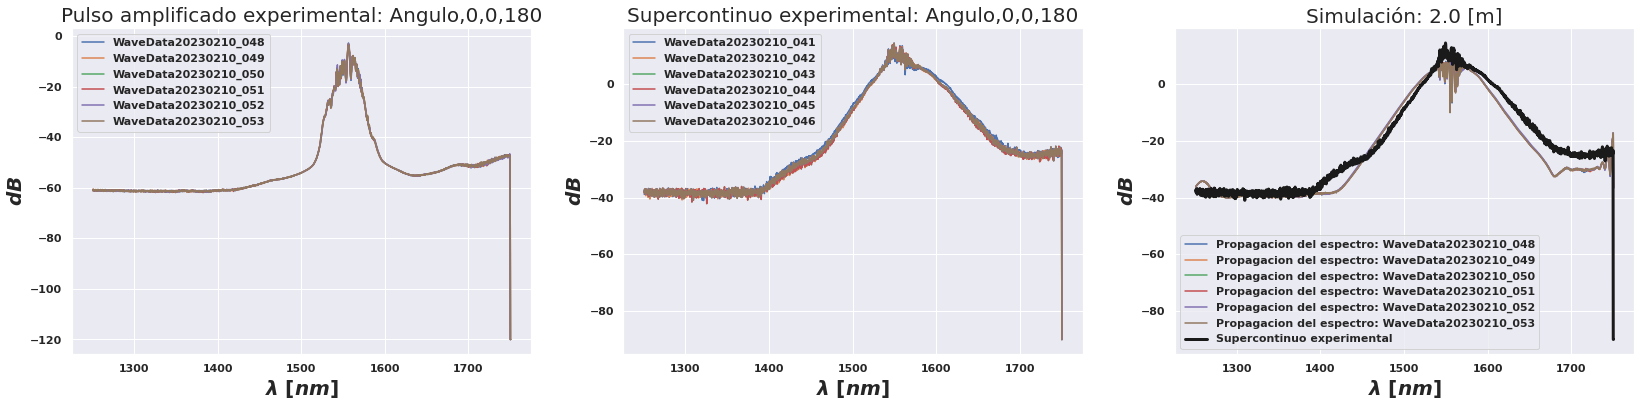

In [54]:
# Load File
f=plt.figure(figsize=(28,6))
names='WaveData20230210_0'
names2='WaveData20230210_0'
pruebaS_1=[names+str(i) for i in range(41,48)]
pruebaP_1=[names2+str(i) for i in range(48,54)]
names_P=[]
names_S=[]


plt.subplot(1,3,1)
for k in range(len(pruebaP_1)):

  path_fileS=path+'/Pulsos_lab/10_feb'+'/'+pruebaS_1[k]+'.csv'
  path_fileP=path+'/Pulsos_lab/10_feb'+'/'+pruebaP_1[k]+'.csv'
  names_P.append(path_fileP)
  names_S.append(path_fileS)

 
  df_P = pd.read_csv(path_fileP,skiprows=52)
  power_P=np.array(df_P['Level(A)'][:])
  WL_P=np.array(df_P['Wavelength(A)'][:])  #Wavelenght
  powerlog_S= 10*np.log10(power_P) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(  WL_P,  powerlog_S,label=pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Pulso amplificado experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  plt.legend()

plt.subplot(1,3,2)
for k in range(len(pruebaP_1)):


  df_S= pd.read_csv(names_S[k],skiprows=52)
  power_S=np.array(df_S['Level(A)'][:])
  WL_s=np.array(df_S['Wavelength(A)'][:])  #Wavelenght
  powerlog_S= 10*np.log10(power_S/1e-3) #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s, powerlog_S,label=pruebaS_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Supercontinuo experimental: Angulo,0,0,180',fontsize=20)
  plt.ylabel('$dB$' ,fontsize=20)
  #plt.ylim(-100,10)
  plt.legend()



plt.subplot(1,3,3)
for k in range(len(pruebaP_1)):

  skip=52

  y,z=propagar_lab(names_P[k],19,skip)
  epsilon1=1e-40
  In1=np.abs(y.y.T[-1])**2
  #In=np.where(In1!=0,In1,In1+epsilon1)
  lIW = 10*np.log10(In1)+235 #2*np.pi*c/WL**2) # log scale spectral intensity
  plt.plot(WL_s,lIW,label='Propagacion del espectro: '+pruebaP_1[k])
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Simulación: '+str(round(z[-1],3))+' [m]',fontsize=20)
  plt.ylabel('$dB$',fontsize=20)
  #plt.ylim(-100,10)

  plt.legend()
  

plt.plot(WL_s, powerlog_S,'k',label='Supercontinuo experimental',linewidth=3)
plt.legend()
super_con.append(powerlog_S)
propagar.append(path_fileP)

In [38]:
def anim2(k,m):
    f = plt.figure(figsize=(13, 4),dpi=200)
    # plot resultados
    #jojasfjas
    y,z=propagar_lab(names_P[0],k,52)
    In1=np.abs(y.y.T[-1])**2    
    lIW = 10*np.log10(In1)+m#2*np.pi*c/WL**2) # log scale spectral intensity

    #plt.plot(WL_s,lIW[0],label='in')
    plt.plot(WL_s,lIW,label='Simulación de supercontinuo')
    plt.plot(WL_s, powerlog_S,'k',label='Supercontinuo experimental',linewidth=3)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('$dB$' )
    #plt.ylim(-100,10)
    plt.legend()
    #plt.xlim(1300,1800)
   
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        k= widgets.FloatSlider(min=0,max=30,value=20,step=1,**opc),
        m= widgets.FloatSlider(min=0,max=300,value=207,step=1,**opc)
     
        
        #mm
        );

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='k', max=30.0, readout_form…

# Polarización.

In [55]:

def Delta_landa(f_ajust,x_data,err):
    Y=f_ajust(x_data)
    medium_value=np.max(Y)-20
    M_V_d=[];M_V=[]
    
    for i in range(len(Y)):
        #print(Y)
        if abs(Y[i]-medium_value)<err:
            M_V_d.append(abs(Y[i]-medium_value))
            M_V.append(i)
    
    
    j=M_V_d.index(np.min(M_V_d)) #Indice de de valor de menor diferencia
    x1=x_data[M_V[j]]; y1=Y[M_V[j]] #Primer par de puntos
    del(M_V_d[j]); del(M_V[j]) #Eliminamos el punto
    
    k=M_V_d.index(min(M_V_d)) #Indice de de valor de menor diferencia nuevo
    x2=x_data[M_V[k]]; y2=Y[M_V[k]]#Segundo par de puntos
    DELTA_LANDA=abs(x2-x1)
    delta_landa_ref=16.026

    return DELTA_LANDA

In [69]:
from scipy.interpolate import CubicSpline
a=0.133; N=1; d=5e-6; wl=1550e-9; D=56e-3  #Parametros del retardo.

#gamma=2*np.pi**2*a*N*d**2/(wl*D)
p=np.pi/180

def Tt(theta,gamma):
    T=np.array([[np.cos(theta*p-np.pi/2)**2+np.exp(-1j*gamma)*np.sin(theta*p-np.pi/2)**2,np.cos(theta*p-np.pi/2)*np.sin(theta*p-np.pi/2)*(1-np.exp(-1j*gamma))],
               [np.cos(theta*p-np.pi/2)*np.sin(theta*p-np.pi/2)*(1-np.exp(-1j*gamma)),np.sin(theta*p-np.pi/2)**2+np.exp(-1j*gamma)*np.cos(theta*p-np.pi/2)**2]])
    return T


In [70]:
def anim2(ep,ang1,ang2,ang3):
    
    f = plt.figure(figsize=(25, 5),dpi=200)
    
    ep = float(ep)   #se elije h como el parámetro que varía, son a su vez las condiciones iniciales 

    ang1=float(ang1)
    ang2=float(ang2)
    ang3=float(ang3)

    x0 = 10; y0 = 0  # Amplitudes de los campos en cada eje coordenado 
      # Fase de retardo en cada eje coordenado (un ej: 1*np.pi/2)
    wt = np.arange(0,2*np.pi,0.1) # Rango de wt
    

    Ex = x0*np.cos(-wt)
    Ey = y0*np.cos(-wt + ep)
    
    xm = np.min(Ex) - 1.5
    xM = np.max(Ex) + 1.5
    ym = np.min(Ey) - 1.5
    yM = np.max(Ey) + 1.5
    
    plt.subplot( 1,3, 1)

    plt.plot(Ex,Ey,'k-',linewidth=2,label='$Desfase=$'+str(round(ep,3)))

    plt.xlabel('$Ex$')
    plt.ylabel('$Ey$')
    plt.xlim(np.min([xm,ym]),np.max([xM,yM]))
    plt.ylim(np.min([xm,ym]),np.max([xM,yM]))
    plt.legend()
    plt.title('Polarización de entrada a la entrada de las paletas')
    
    plt.subplot( 1,3, 2)
    
    desf1=np.pi/2 ; desf2=np.pi; desf3=np.pi/2;  #Gammas
    
    T1=Tt(ang1, desf1) ; T2=Tt(ang2, desf2) ; T3=Tt(ang3, desf3)
    
    T=T3@T2@T1
    
    phix=0 ; phiy=ep

    J1=np.array([x0*np.exp(1j*phix),y0*np.exp(1j*phiy)])
    
    J2=T@J1
    
    Ex = np.abs(J2[0])*np.cos(-wt+np.angle(J2[0]))
    Ey = np.abs(J2[1])*np.cos(-wt+ep+np.angle(J2[1]))
    
    plt.plot(Ex,Ey,'k-',linewidth=2,label='$Desfase=$'+str(round(ep,3)))
    #plt.plot(x,y2,'b-',linewidth=1,label=str(w_1))
    #plt.plot(x,z_cerca_1,'g-',linewidth=1,label='k=0.1')
    plt.xlabel('$Ex$')
    plt.ylabel('$Ey$')
    plt.xlim(np.min([xm,ym]),np.max([xM,yM]))
    plt.ylim(np.min([xm,ym]),np.max([xM,yM]))
    plt.legend()
    plt.title('Polarización a la salida de las paletas.')
    
    # Propagación.
    plt.subplot(1,3,3)

    inicial=np.sqrt(x0**2+y0**2)
    finalx=np.abs(J2[0])**2/(x0**2+y0**2)
    finaly=np.abs(J2[1])**2/(x0**2+y0**2)

    y1,z1=propagar_lab(names_P[0],27.1*finalx,52)
    In1=np.abs(y1.y.T[-1])**2    
    y2,z2=propagar_lab(names_P[0],27.1*finaly,52)
    In2=np.abs(y2.y.T[-1])**2    
    lIW = 10*np.log10(In1+In2)+234  #2*np.pi*c/WL**2) # log scale spectral intensity
    cs = CubicSpline(WL_s,lIW)
    new_wl=np.linspace(min(WL_s),max(WL_s),10000)
    ancho_esp=Delta_landa(cs,new_wl,0.1)

    #plt.plot(WL_s,lIW[0],label='in')
    plt.plot(WL_s,lIW,label='Simulación de supercontinuo')
    plt.plot(WL_s, super_con[0],'k',label='Supercontinuo experimental: 0,0,180',linewidth=2.5)
    plt.plot(WL_s, super_con[1],'r',label='Supercontinuo experimental: max,0,max',linewidth=2.5)
    #plt.plot(WL_s, cs(WL_s),'r',label='Supercontinuo experimental: max,0,max',linewidth=2.5)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title('Ancho espectral simulacion: '+str(round(ancho_esp,3)))
    plt.ylabel('$dB$' )
    #plt.ylim(-100,10)
    plt.legend()
    #plt.xlim(1300,1800)
   
  
  
    
    
    

In [89]:
opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        ep= widgets.FloatSlider(min=0.001,max=np.pi,value=1,step=0.1,**opc), 
        ang1=widgets.FloatSlider(min=0,max=180,value=1,step=1,**opc),
        ang2= widgets.FloatSlider(min=0,max=180,value=1,step=1,**opc),
        ang3= widgets.FloatSlider(min=0,max=90,value=1,step=1,**opc),
        #mm
        );



interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='ep', max=3.141592653589793,…

# Comparación con resultados experimentales.

In [76]:
def prop_ang(ang1,ang2,ang3):
 
    
    ep = 0   #se elije h como el parámetro que varía, son a su vez las condiciones iniciales 

    ang1=float(ang1)
    ang2=float(ang2)
    ang3=float(ang3)

    x0 = 10; y0 = 0  # Amplitudes de los campos en cada eje coordenado 
      # Fase de retardo en cada eje coordenado (un ej: 1*np.pi/2)
    wt = np.arange(0,2*np.pi,0.1) # Rango de wt
    

    Ex = x0*np.cos(-wt)
    Ey = y0*np.cos(-wt + ep)
   
    desf1=np.pi/2 ; desf2=np.pi; desf3=np.pi/2;  #Gammas
    
    T1=Tt(ang1, desf1) ; T2=Tt(ang2, desf2) ; T3=Tt(ang3, desf3)
    
    T=T3@T2@T1
    
    phix=0 ; phiy=ep

    J1=np.array([x0*np.exp(1j*phix),y0*np.exp(1j*phiy)])
    
    J2=T@J1
    
    Ex = np.abs(J2[0])*np.cos(-wt+np.angle(J2[0]))
    Ey = np.abs(J2[1])*np.cos(-wt+ep+np.angle(J2[1]))
    

    inicial=np.sqrt(x0**2+y0**2)
    finalx=np.abs(J2[0])**2/(x0**2+y0**2)
    finaly=np.abs(J2[1])**2/(x0**2+y0**2)

    y1,z1=propagar_lab(names_P[0],27.1*finalx,52)
    In1=np.abs(y1.y.T[-1])**2    
    y2,z2=propagar_lab(names_P[0],27.1*finaly,52)
    In2=np.abs(y2.y.T[-1])**2    
    lIW = 10*np.log10(In1+In2)+234  #2*np.pi*c/WL**2) # log scale spectral intensity
    cs = CubicSpline(WL_s,lIW)
    new_wl=np.linspace(min(WL_s),max(WL_s),10000)
    ancho_esp=Delta_landa(cs,new_wl,0.1)

    return ancho_esp
  



Text(0, 0.5, '$\\theta_1$')

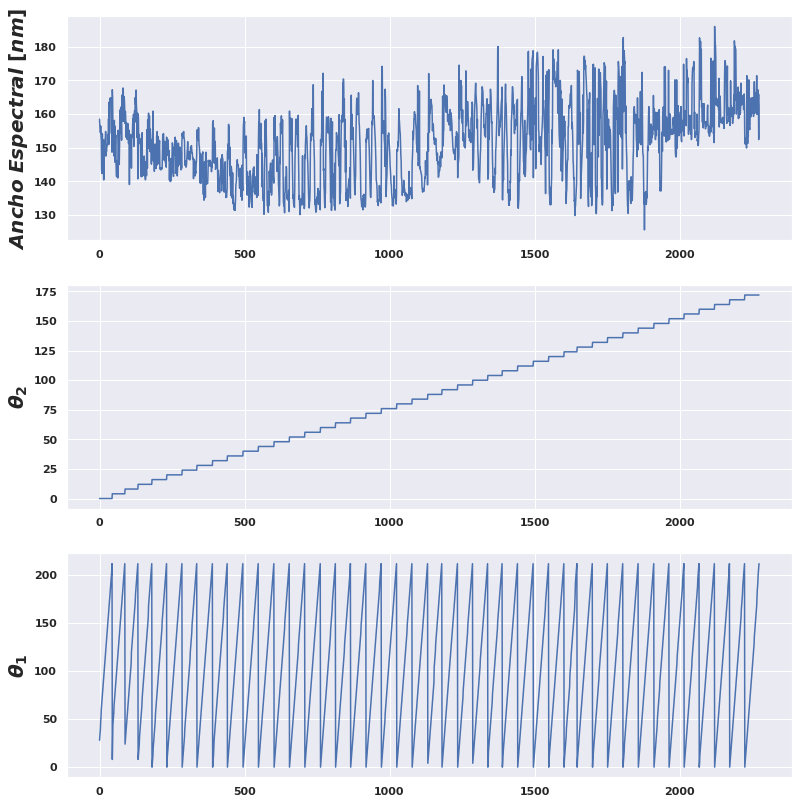

In [80]:
# Load File

f1=plt.figure(figsize=(13,14))
dir=[]

for filename in os.listdir(path+'/Pulsos_lab/Datos_Juan/DataSets_Prueba_3_K_2'):

    
  dir.append(path+'/Pulsos_lab/Datos_Juan/DataSets_Prueba_3_K_2'+'/'+filename)

path_file=dir[0]

df = pd.read_csv(path_file)
teta1=np.array(df['Theta1'][:])
teta2=np.array(df['Theta2'][:])
teta3=np.array(df['Theta3'][:])
Ancho_espec=np.array(df['Ancho_espectral'][:])
Potencia=np.array(df['Potencia'][:])


plt.subplot(3,1,1)

plt.plot(Ancho_espec*14.5)
plt.ylabel('$Ancho$ $Espectral$ $[nm]$' ,fontsize=20)


plt.subplot(3,1,2)

plt.plot(teta2)
plt.ylabel(r'$\theta_2$' ,fontsize=20)

plt.subplot(3,1,3)

plt.plot(teta1)
plt.ylabel(r'$\theta_1$' ,fontsize=20)


#plt.legend()





In [82]:
ancho_sim=[]

for k in range(len(teta1)):
  ancho_sim.append(prop_ang(teta1[k],teta2[k],teta3[k]))

Text(0, 0.5, '$\\theta_1$')

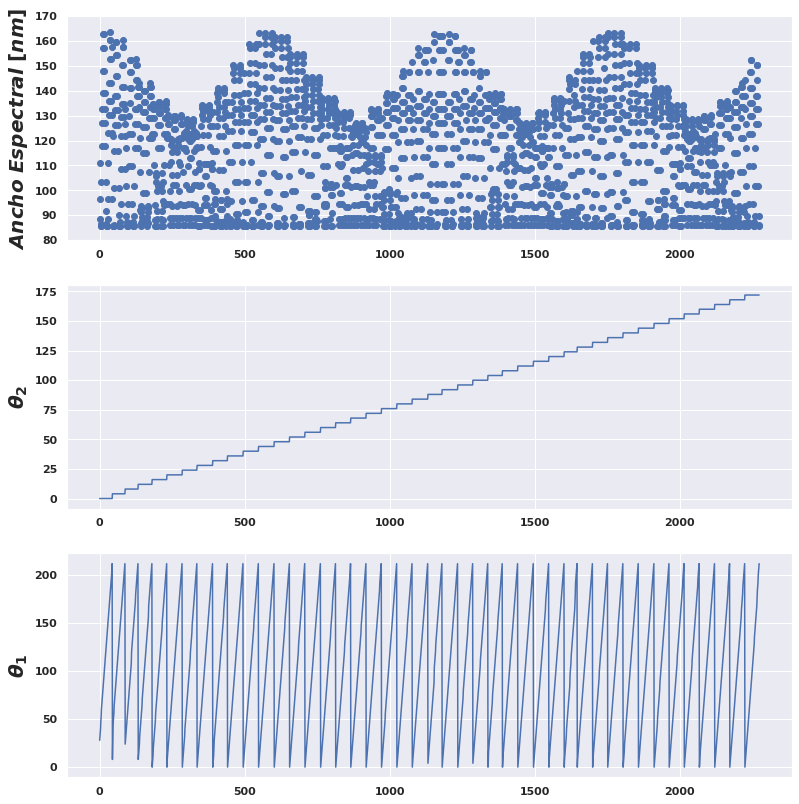

In [88]:


f1=plt.figure(figsize=(13,14))
plt.subplot(3,1,1)

plt.plot(ancho_sim,'o')
plt.ylabel('$Ancho$ $Espectral$ $[nm]$' ,fontsize=20)
plt.ylim(80,170)


plt.subplot(3,1,2)

plt.plot(teta2)
plt.ylabel(r'$\theta_2$' ,fontsize=20)

plt.subplot(3,1,3)

plt.plot(teta1)
plt.ylabel(r'$\theta_1$' ,fontsize=20)


# Otros resultados de interes.

# Resultados del Lab

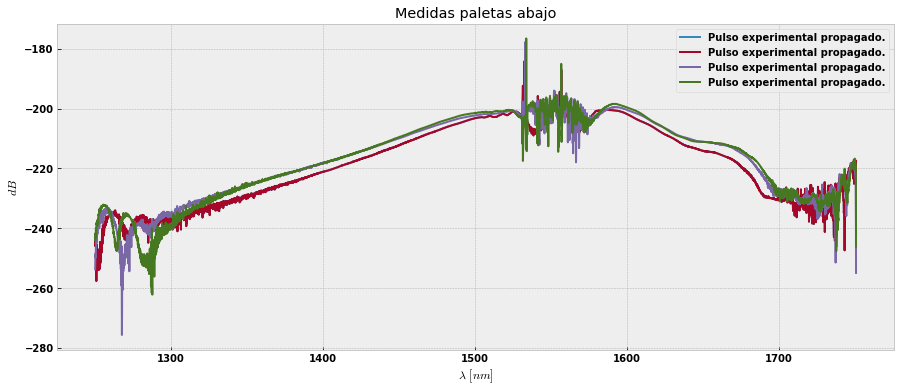

In [ ]:
# Load File

f=plt.figure(figsize=(15,6))

name='Medidas paletas abajo'
dir=path+'/Pulsos_lab/Medidas 31-01-2023/Nueva carpeta/'+name
dir_exp=path+'/Pulsos_lab/MUESTRA_0_0_50.csv'

df = pd.read_csv(dir_exp,skiprows=28)
power_exp=np.array(df['Level(A)'][:])*1e-3
epsilon1=1e-11
power_exp=np.where(power_exp>epsilon1,power_exp,epsilon1)*3.620**2

WL_exp=np.array(df['Wavelength(A)'][:])  #Wavelenght

for filename in os.listdir(path+'/Pulsos_lab/Medidas 31-01-2023/Nueva carpeta/'+name):

  path_file=dir+'/'+filename
  y,z=propagar_lab(path_file,8.3,52)
  W=V2
  WL = ((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid
  
  epsilon1=1e-20
  In1=np.abs(y.y.T)**2
  In=np.where(In1!=0,In1,In1+epsilon1)
  lIW = 10*np.log10(In/1e-3) #2*np.pi*c/WL**2) # log scale spectral intensity
  
  plt.plot(WL*1e9,lIW[-1],label='Pulso experimental propagado.')
  plt.xlabel('$\lambda$ $[nm]$')
  plt.title(name)
  plt.ylabel('$dB$' )
  #plt.ylim(-100,10)
  plt.legend()
  #plt.xlim(1300,1800)

lIW_exp = 10*np.log10(power_exp*1e-15*0.5) #2*np.pi*c/WL**2) # log scale spectral intensity
#plt.plot(WL_exp,lIW_exp ,label='Experimental')
#plt.legend()


# Pulsos Daniel.

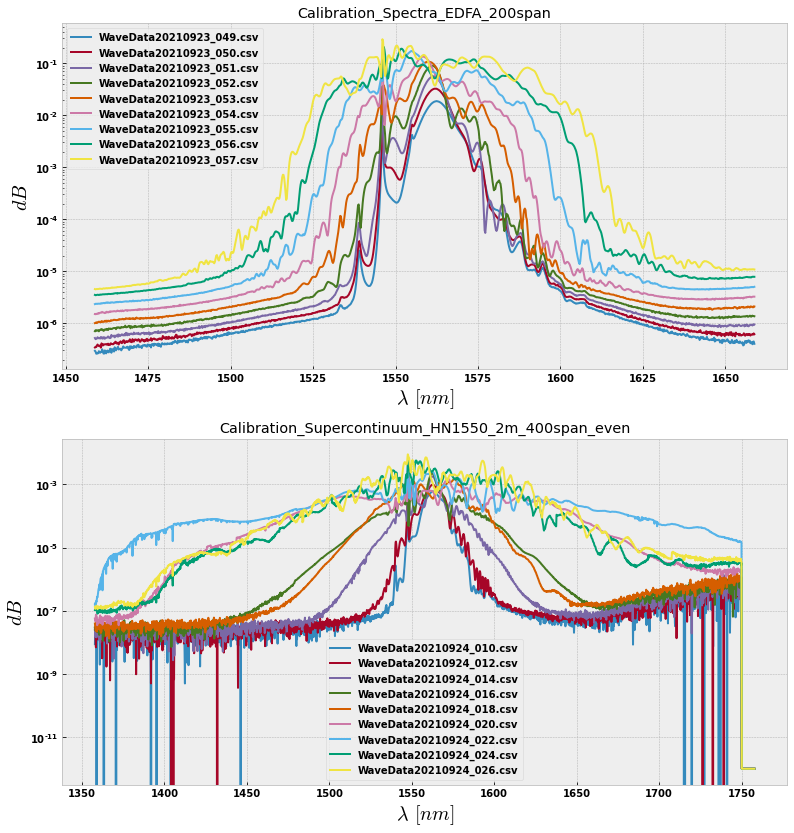

In [ ]:
# Load File

f=plt.figure(figsize=(13,14))

plt.subplot(2,1,1)

for filename in os.listdir(path+'/Pulsos_lab/Medidas daniel/Calibration_Spectra_EDFA_200span'):

  path_file=path+'/Pulsos_lab/Medidas daniel/Calibration_Spectra_EDFA_200span'+'/'+filename

  df = pd.read_csv(path_file,skiprows=28)
  power_exp=np.array(df['Level(A)'][:])

  WL_exp=np.array(df['Wavelength(A)'][:])  #Wavelenght


  plt.plot(  WL_exp,  power_exp,label=filename)
  plt.yscale('log')
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Calibration_Spectra_EDFA_200span')
  plt.ylabel('$dB$' ,fontsize=20)
  #plt.ylim(-100,10)
  plt.legend()
  #plt.xlim(1300,1800)


#plt.legend()


plt.subplot(2,1,2)

for filename in os.listdir(path+'/Pulsos_lab/Medidas daniel/Calibration_Supercontinuum_HN1550_2m_400span_even'):

  path_file=path+'/Pulsos_lab/Medidas daniel/Calibration_Supercontinuum_HN1550_2m_400span_even'+'/'+filename

  df = pd.read_csv(path_file,skiprows=28)
  power_exp=np.array(df['Level(A)'][:])

  WL_exp=np.array(df['Wavelength(A)'][:]) #Wavelenght


  plt.plot(  WL_exp,  power_exp,label=filename)
  plt.yscale('log')
  plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  plt.title('Calibration_Supercontinuum_HN1550_2m_400span_even')
  plt.ylabel('$dB$',fontsize=20 )
  #plt.ylim(-100,10)
  plt.legend()
  #plt.xlim(1300,1800)


#plt.legend()


# Datos Juan Pablo

<ipython-input-68-1ab4f252ba45>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,1)
<ipython-input-68-1ab4f252ba45>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4,1,2)
<ipython-input-68-1ab4f252ba45>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

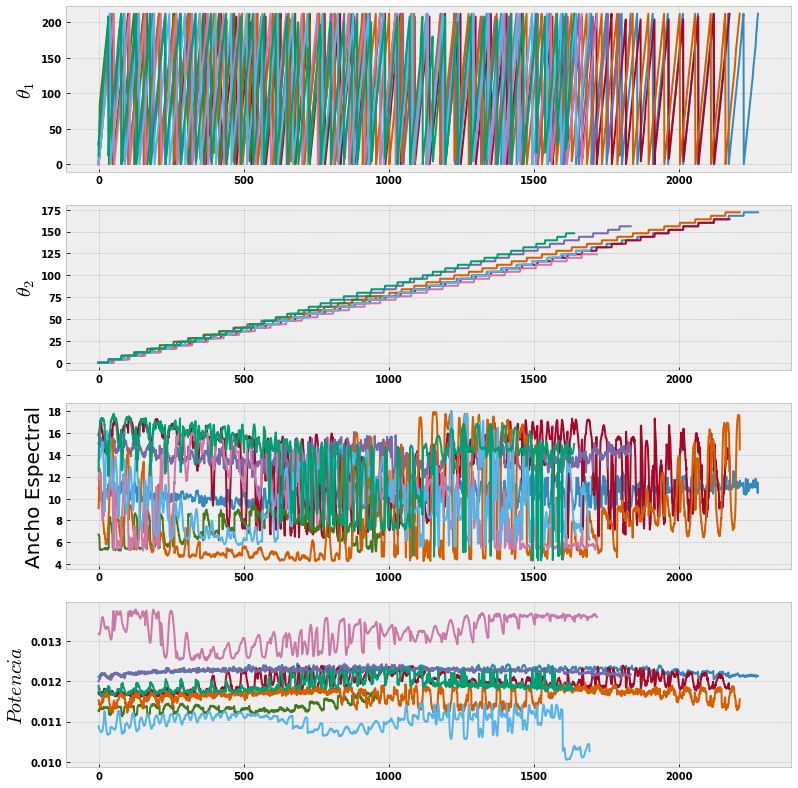

In [ ]:
# Load File

f1=plt.figure(figsize=(13,14))

for filename in os.listdir(path+'/Pulsos_lab/Datos_Juan/DataSets_Prueba_1_K_2'):

    
  path_file=path+'/Pulsos_lab/Datos_Juan/DataSets_Prueba_1_K_2'+'/'+filename

  df = pd.read_csv(path_file)
  teta1=np.array(df['Theta1'][:])
  teta2=np.array(df['Theta2'][:])
  Ancho_espec=np.array(df['Ancho_espectral'][:])
  Potencia=np.array(df['Potencia'][:])

  plt.subplot(4,1,1)

  plt.plot(teta1)
  plt.ylabel(r'$\theta_1$' ,fontsize=20)

  plt.subplot(4,1,2)

  plt.plot(teta2)
  plt.ylabel(r'$\theta_2$' ,fontsize=20)

  plt.subplot(4,1,3)

  plt.plot(Ancho_espec)
  plt.ylabel('Ancho Espectral' ,fontsize=20)

  plt.subplot(4,1,4)

  plt.plot(Potencia)
  plt.ylabel('$Potencia$' ,fontsize=20)
  


#plt.legend()





# Polarización.

In [ ]:
a=0.133; N=1; d=5e-6; wl=1550e-9; D=56e-3  #Parametros del retardo.

#gamma=2*np.pi**2*a*N*d**2/(wl*D)
p=np.pi/180
def Tt(theta,gamma):
    
    
    T=np.array([[np.cos(theta*p)**2+np.exp(-1j*gamma)*np.sin(theta*p)**2,np.cos(theta*p)*np.sin(theta*p)*(1-np.exp(-1j*gamma))],
               [np.cos(theta*p)*np.sin(theta*p)*(1-np.exp(-1j*gamma)),np.sin(theta*p)**2+np.exp(-1j*gamma)*np.cos(theta*p)**2]])
    return T


In [ ]:
def anim2(ep,ang1,ang2,ang3):
    
    f = plt.figure(figsize=(20, 5),dpi=200)
    
    ep = float(ep)   #se elije h como el parámetro que varía, son a su vez las condiciones iniciales 

    ang1=float(ang1)
    ang2=float(ang2)
    ang3=float(ang3)

    x0 = 3; y0 = 0  # Amplitudes de los campos en cada eje coordenado 
      # Fase de retardo en cada eje coordenado (un ej: 1*np.pi/2)
    wt = np.arange(0,2*np.pi,0.1) # Rango de wt
    
    phix=0 ; phiy=ep

    pulse1='WaveData20230131_115'
    pulses='/Pulsos_lab/Medidas 31-01-2023/Nueva carpeta/Medidas paletas abajo/'
    path_file=path+pulses+pulse1+'.csv'

    Ex = x0*np.cos(-wt)
    Ey = y0*np.cos(-wt + ep)
    
    xm = np.min(Ex) - 1.5
    xM = np.max(Ex) + 1.5
    ym = np.min(Ey) - 1.5
    yM = np.max(Ey) + 1.5
    
    plt.subplot( 1,3, 1)

    plt.plot(Ex,Ey,'k-',linewidth=2,label='$Desfase=$'+str(round(ep,3)))

    plt.xlabel('$Ex$')
    plt.ylabel('$Ey$')
    plt.xlim(np.min([xm,ym]),np.max([xM,yM]))
    plt.ylim(np.min([xm,ym]),np.max([xM,yM]))
    plt.legend()
    plt.title('Polarización de entrada: '+str(np.sqrt(x0**2+y0**2)))
    
    plt.subplot( 1,3, 2)
    
    desf1=np.pi/2 ; desf2=np.pi; desf3=np.pi/2;  #
    
    T1=Tt(ang1, desf1) ; T2=Tt(ang2, desf2) ; T3=Tt(ang3, desf3)
    
    T=T3@T2@T1
    
    J1=np.array([x0*np.exp(1j*phix),y0*np.exp(1j*phiy)])
    
    J2=T@J1
    
    Ex = np.abs(J2[0])*np.cos(-wt+np.angle(J2[0]))
    Ey = np.abs(J2[1])*np.cos(-wt+ep+np.angle(J2[1]))
    
    plt.plot(Ex,Ey,'k-',linewidth=2,label='$Desfase=$'+str(round(ep,3)))
    #plt.plot(x,y2,'b-',linewidth=1,label=str(w_1))
    #plt.plot(x,z_cerca_1,'g-',linewidth=1,label='k=0.1')
    plt.xlabel('$Ex$')
    plt.ylabel('$Ey$')
    plt.xlim(np.min([xm,ym]),np.max([xM,yM]))
    plt.ylim(np.min([xm,ym]),np.max([xM,yM]))
    plt.legend()
    plt.title('Polarización de salida: '+str(round(np.sqrt(np.abs(J2[0]**2+np.abs(J2[1]**2))),3)))
    
    # Propagación.
    plt.subplot(1,3,3)

    inicial=np.sqrt(x0**2+y0**2)
    final=np.sqrt(np.abs(J2[0]**2+np.abs(J2[1]**2)))
    por=final/inicial

    pulse1='WaveData20230131_121'
    pulses='/Pulsos_lab/Medidas 31-01-2023/Nueva carpeta/Medidas paletas arriba/'
    path_file=path+pulses+pulse1+'.csv'
    y,z=propagar_lab(path_file,8*por)
    W=V2
    WL = ((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid
    epsilon1=1e-20
    In1=np.abs(y.y.T)**2
    In=np.where(In1!=0,In1,In1+epsilon1)
    lIW = 10*np.log10(In/1e-3) #2*np.pi*c/WL**2) # log scale spectral intensit
    plt.plot(WL*1e9,lIW[-1],label='out')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title('Espectro')
    plt.ylabel('$dB$' )
    plt.legend()
    
    
    

In [ ]:
opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        ep= widgets.FloatSlider(min=0.001,max=np.pi,value=1,step=0.1,**opc), 
        ang1=widgets.FloatSlider(min=0,max=180,value=1,step=0.1,**opc),
        ang2= widgets.FloatSlider(min=0,max=180,value=1,step=0.1,**opc),
        ang3= widgets.FloatSlider(min=0,max=180,value=1,step=0.1,**opc),
        #mm
        );



interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='ep', max=3.141592653589793,…